In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import random as rand
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import utils
from matplotlib import pyplot as plt

# Bayesian Modelling

In [3]:
# True Gaussian distribution from which data is generated
muAst = 3
sigmaAst = 2

# Number of samples
n = 10

# Get samples
X = rand.normal( muAst, sigmaAst, n )

# Make samples into 2D points so that they can be plotted
X2D = np.ones( (n, 2) ) * -0.1
X2D[:,0] = X

# A global variable (sorry - I know global vars are bad) to plot the MAP estimate
mode = 0

def getPDFGaussian( X ):
    global sigma, mu
    return 1/np.sqrt( 2 * np.pi * np.square(sigma) ) * np.exp( -np.square( X - mu )/(2 * np.square( sigma )) )

def getPDFUniform( X ):
    global a, b
    pdf = np.ones( X.shape ) * 1/(b - a)
    pdf[X < a] = 0
    pdf[X > b] = 0
    return pdf

def getPosterior( W ):
    global mode, priorPDF, X
    prior = priorPDF( W )
    temp = utils.getAllPairsDistances( W[:, np.newaxis], X[:, np.newaxis] )
    likelihood = np.prod( np.exp(-temp/(2 * np.square( sigmaAst ))), axis = 1)
    posterior = np.multiply( prior, likelihood )
    # It is tedious to do the exact integration so we normalize the crude way
    posterior = posterior/np.sum( posterior )
    # Set the mode variable so that we may plot it outside
    mode = W[np.argmax( posterior )]
    return posterior

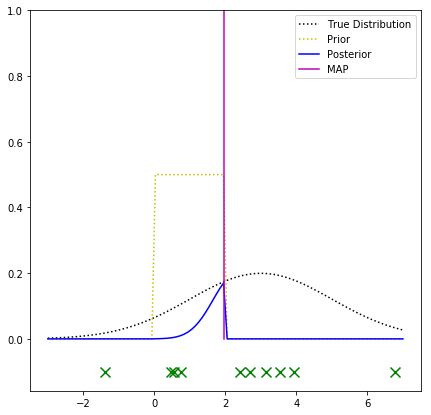

In [4]:
# Uniform Prior
a = 0
b = 2

nBins = 100
priorPDF = getPDFUniform

mu = muAst
sigma = sigmaAst

# We will notice that since the prior excludes the true muAst, the MAP procedure will
# instead offer the model most suitable within the support of the prior (at one extreme)
# end of the support of the prior. On the other hand, if we set the support to be something
# like a = 4, b = 6, then you will find MAP latching on to the other extreme end of the support
# The is no accident -- the MAP does indeed compute a constrained optimization problem in this case

# However, if we use a less restrictive prior that does include the true muAst, for example
# a = -5, b = 5, then the MAP procedure, when given enough data points (say set n = 200 or so)
# will recover muAst very faithfully
fig = pd.getFigure( 7, 7 )
pd.plotCurve( getPDFGaussian, fig, mode = "batch", color = 'k', linestyle = ':', xlimL = -3, xlimR = 7, nBins = nBins, label = "True Distribution" )
pd.plot2D( X2D, fig, color = 'g', marker = 'x', size = 100 )
pd.plotCurve( getPDFUniform, fig, mode = "batch", color = 'y', linestyle = ':', xlimL = -3, xlimR = 7, nBins = nBins, label = "Prior" )
pd.plotCurve( getPosterior, fig, mode = "batch", color = 'b', linestyle = '-', xlimL = -3, xlimR = 7, nBins = nBins, label = "Posterior" )
pd.plotVerticalLine( mode, fig, color = 'm', linestyle = '-', yLimB = 0, yLimT = 1, nBins = nBins, label = "MAP")
plt.ylim( top = 1.0 )
plt.show()

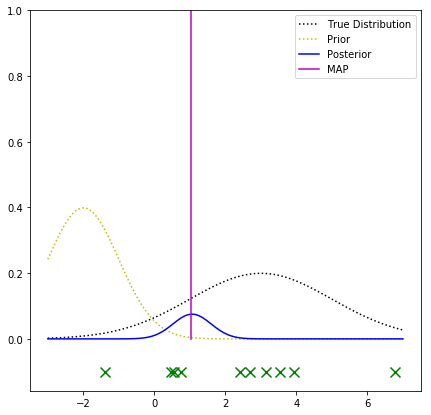

In [5]:
mu = muAst
sigma = sigmaAst

fig2 = pd.getFigure( 7, 7 )
pd.plotCurve( getPDFGaussian, fig2, mode = "batch", color = 'k', linestyle = ':', xlimL = -3, xlimR = 7, nBins = nBins, label = "True Distribution" )
pd.plot2D( X2D, fig2, color = 'g', marker = 'x', size = 100 )

# Let us instead use a Gaussian prior
muPrior = -2
sigmaPrior = 1

mu = muPrior
sigma = sigmaPrior
priorPDF = getPDFGaussian

# Notice that the posterior distribution also looks suspiciously Gaussian in this case.
# Try changing the parameters of the prior and confirm that the posterior continues to
# look like a Gaussian. This is again no accident -- the posterior is actually a Gaussian.
# If our prior and likelihood distributions are both Gaussian then the posterior distribution
# will also be Gaussian -- this is due to a beautiful phenonmenon called conjugacy which
# we will briefly look in this course very soon -- more details in advanced courses like CS772
pd.plotCurve( getPDFGaussian, fig2, mode = "batch", color = 'y', linestyle = ':', xlimL = -3, xlimR = 7, nBins = nBins, label = "Prior" )
pd.plotCurve( getPosterior, fig2, mode = "batch", color = 'b', linestyle = '-', xlimL = -3, xlimR = 7, nBins = nBins, label = "Posterior" )
pd.plotVerticalLine( mode, fig2, color = 'm', linestyle = '-', yLimB = 0, yLimT = 1, nBins = nBins, label = "MAP")
plt.ylim( top = 1.0 )
plt.show()

# Learning Gaussian Mixture Models using the EM algorithm

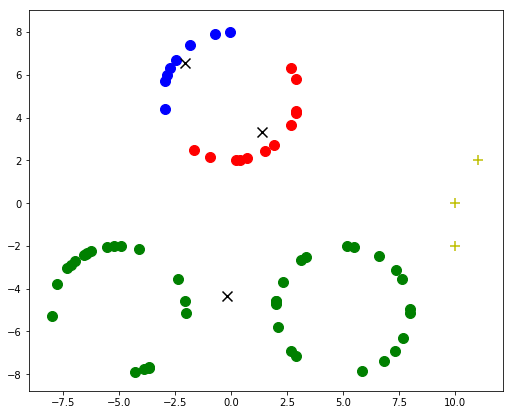

In [6]:
d = 2 
n = 20
r = 3

mu1 = np.array( [0,5] )
mu2 = np.array( [-5,-5] )
mu3 = np.array( [5,-5] )

tmp1 = gsd.genSphericalData( d, n, mu1, r )
tmp2 = gsd.genSphericalData( d, n, mu2, r )
tmp3 = gsd.genSphericalData( d, n, mu3, r )
X = np.vstack( (tmp1, tmp2, tmp3) )

# Perform soft assignments
def getSoftAssignments( X, muVals ):
    pi = np.exp( -utils.getAllPairsDistances( X, muVals )/2 )
    rowSum = pi.sum( axis = 1 )
    pi = pi / rowSum[:, np.newaxis]
    return pi

# Update every centroid to the weighted mean of all data points
def updateCentroidsSoftly( X, pi, k, prevMuVals ):
    muVals = np.zeros( (k, X.shape[1]) )
    for i in range( k ):
        z = pi[:, i]
        amountData = sum(z)
        # Recall that in soft clustering, only part of a data point may be assigned to a cluster
        # Thus, amountData could be a fractional value as well
        if amountData > 1:
            muVals[i,:] = (X.T).dot(z)/amountData
        # If some cluster is almost empty, return the old value of its centroid
        else:
            muVals[i,:] = prevMuVals[i,:]
    return muVals

# Execute the soft k-means (i.e. the EM) algorithm
def doSoftkmeans( X, k, init, niter ):
    muVals = init
    # Perform the EM algorithm for niter steps
    for t in range( niter ):
        pi = getSoftAssignments( X, muVals ) # E Step
        muVals = updateCentroidsSoftly( X, pi, k, muVals ) # M Step
    return (muVals, pi)

init = np.array( [[10,0], [10,-2], [11,2]] )
# Even the soft k-means algorithm (EM algorithm) can get stuck if not initialized properly
# Proper initialization is an absolute must for the EM algorithm as well
# No matter how long we run EM, it does not get unstuck
(muVals, pi) = doSoftkmeans( X, 3, init, 1000)

fig = pd.getFigure( 8.5, 7 )
pd.plot2D( X[pi[:,0] > 0.5 ], fig, color = 'r', marker = 'o' )
pd.plot2D( X[pi[:,1] > 0.5 ], fig, color = 'g', marker = 'o' )
pd.plot2D( X[pi[:,2] > 0.5 ], fig, color = 'b', marker = 'o' )
pd.plot2D( muVals, fig, color = 'k', marker = 'x' )
pd.plot2D( init, fig, color = 'y', marker = '+' )

# Mixed Regression using the EM algorithm

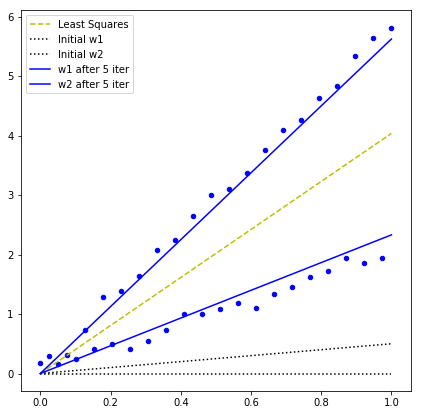

In [7]:
def doLSReg( X, y, weights = [] ):
    # If no weights are specified, do usual least squares
    if len(weights) == 0:
        return 1/(np.sum( np.square( X ))) * X.dot( y )
    # Else if weights are specified, solve the weighted least squares problem
    else:
        return 1/(weights.dot( np.square( X ))) * X.dot( np.multiply( weights, y ) )

def doEStep( X, y, wVals ):
    residuals = np.matmul( X[:,np.newaxis], wVals[np.newaxis,:] ) - y[:,np.newaxis]
    qVals = np.exp( -np.square( residuals ) / 2 )
    rowSum = qVals.sum( axis = 1 )
    qVals = qVals / rowSum[:, np.newaxis]
    return qVals

def doMStep( X, y, qVals, C, prevWVals ):
    wVals = np.zeros( prevWVals.shape )
    
    # Process every component
    for c in range( C ):
        # Get hold of the weights different data points have given to this component
        q = qVals[:, c]
        amountData = sum(q)
        # If there is enough data for this component, do weighted least squares to get the weighted MLE
        if amountData > 1:
            wVals[c] = doLSReg( X, y, weights = q )
        # If some cluster is almost empty, return the old value of the model for this component
        else:
            wVals[c] = prevWVals[c]
    return wVals

def doEMMR( X, y, C, init, niter ):
    wVals = init
    for t in range( niter ):
        qVals = doEStep( X, y, wVals )
        wVals = doMStep( X, y, qVals, C, wVals )
    return (wVals, qVals)

n = 40

X = np.linspace( 0, 1, n, endpoint = True )
wAst1 = 2
wAst2 = 6
noise = rand.normal( 0, 0.1, (n,) )
y = np.zeros( X.shape )
y[::2] = X[::2] * wAst1
y[1::2] = X[1::2] * wAst2
y = y + noise

wHat = doLSReg( X, y )

fig = pd.getFigure( 7, 7 )
pd.plot2D( np.hstack( (X[:, np.newaxis], y[:, np.newaxis]) ), fig, color = 'b', marker = 'o', size = 20 )
pd.plotLine( np.array( [wHat, -1] ) , 0, fig, color = 'y', linestyle = "--", xlimL = 0, xlimR = 1, label = "Least Squares" )

# Careful initialization is required here, just as it was for (soft) k-means
# If we initialize both models to be equal in the beginning, then the procedure cannot learn two components
# Try setting, for example, init = np.array( [1,1] ) and see for yourself
init = np.array( [0,0.5] )
pd.plotLine( np.array( [init[0], -1] ) , 0, fig, color = 'k', linestyle = ":", xlimL = 0, xlimR = 1, label = "Initial w1" )
pd.plotLine( np.array( [init[1], -1] ) , 0, fig, color = 'k', linestyle = ":", xlimL = 0, xlimR = 1, label = "Initial w2" )

# The EM algorithm is very quick at identifying that there are two populations in the data
# Within very few iterations, it converges to the two models
C = 2
niter = 5
(wVals, qVals) = doEMMR( X, y, C, init, niter)

pd.plotLine( np.array( [wVals[0], -1] ) , 0, fig, color = 'b', linestyle = "-", xlimL = 0, xlimR = 1, label = "w1 after %s iter" % niter )
pd.plotLine( np.array( [wVals[1], -1] ) , 0, fig, color = 'b', linestyle = "-", xlimL = 0, xlimR = 1, label = "w2 after %s iter" % niter )